In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Image Rotation

# Generate a list of rotated images

In [3]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt

# angles = for k in range(15, 181, 15)
# angles = [15,30,45,60,75,90,105,120,135,150,165,180]
angle = 30

def rotate_images(images, angle):
    rotated_images = []
    for img in images:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        # rotated_image = ndimage.rotate(img, angle, reshape=True)
        rotated_images.append(rotated_image)
    return rotated_images

train_rotated_images = rotate_images(train_dataset.data, angle)
test_rotated_images = rotate_images(test_dataset.data, angle)

train_rotated_images = np.array(train_rotated_images)
test_rotated_images = np.array(test_rotated_images)
print("Train rotated images shape")
print(train_rotated_images.shape)

print("Test rotated images shape")
print(test_rotated_images.shape)



Train rotated images shape
(50000, 32, 32, 3)
Test rotated images shape
(10000, 32, 32, 3)


# Visualizing generated rotated images

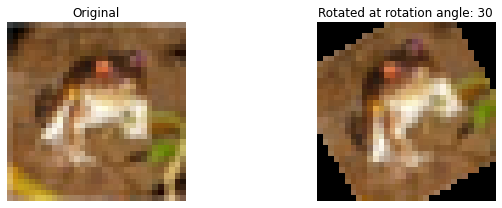

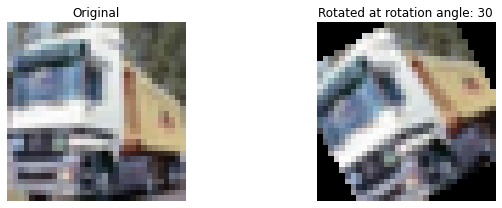

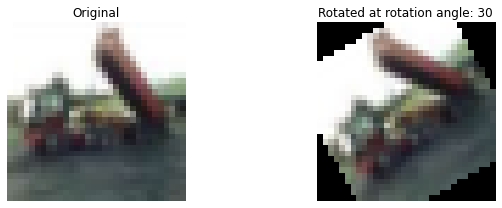

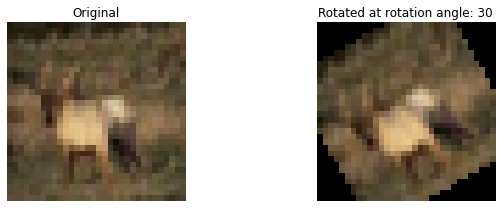

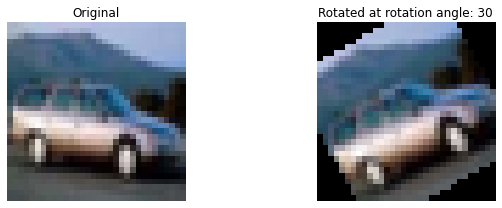

In [4]:
i=0
for rotated_image in train_rotated_images:
    fig = plt.figure(figsize=(10, 3))
    ax1,ax2 = fig.subplots(1,2)
    ax1.imshow(train_dataset.data[i], cmap='gray')
    ax1.set_axis_off()
    ax1.set_title("Original")
    ax2.imshow(rotated_image, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title("Rotated at rotation angle: "+str(angle))
    fig.set_tight_layout(True)
    plt.show()
    i +=1
    
    if i==5:
        break
    

# Combining original and rotated images

In [5]:
original_image_labels = np.zeros(len(train_dataset.data))
rotated_image_labels = np.ones(len(train_rotated_images))

test_original_image_labels = np.zeros(len(test_dataset.data))
test_rotated_image_labels = np.ones(len(test_rotated_images))

train_original_and_rotated_images = np.concatenate((train_dataset.data, train_rotated_images), axis=0)
train_rotation_labels = np.concatenate((original_image_labels, rotated_image_labels), axis=None)
train_image_labels = np.concatenate((train_dataset.targets, train_dataset.targets), axis=None)

test_original_and_rotated_images = np.concatenate((test_dataset.data, test_rotated_images), axis=0)
test_rotation_labels = np.concatenate((test_original_image_labels, test_rotated_image_labels), axis=None)


print("Combined rotated and original images shape")
print(train_original_and_rotated_images.shape)


Combined rotated and original images shape
(100000, 32, 32, 3)


# Extract image features

In [6]:
from image_feature_extractor import Img2Vec

img2vec = Img2Vec()

Z = img2vec.get_vec(train_original_and_rotated_images)

Z_test = img2vec.get_vec(test_original_and_rotated_images)

Z_test_original = img2vec.get_vec(test_dataset.data)

Z_test_rotated = img2vec.get_vec(test_rotated_images)

# vec.shape
print("Shape of extracted features for combined rotated and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for rotated test images")
print(Z_test_rotated.shape)


Shape of extracted features for combined rotated and original images
(100000, 512)
Shape of extracted features for original test images
(10000, 512)
Shape of extracted features for rotated test images
(10000, 512)


# Obtaining rotation prediction coefficients

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_rotation_labels)

rotation_coefficients = lr_model.coef_.reshape(-1,1)
rotation_coefficients = rotation_coefficients / np.linalg.norm(rotation_coefficients)

# print("Printing some of rotation coefficients")
# print(rotation_coefficients[:5,:])
# print()
print("Rotation coefficients shape")
print(rotation_coefficients.shape)

print('Rotation prediction accuracy on training data: ', lr_model.score(Z, train_rotation_labels))

print('Rotation prediction accuracy on test data-rotated and original combined: ', lr_model.score(Z_test, test_rotation_labels))

    


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Rotation coefficients shape
(512, 1)
Rotation prediction accuracy on training data:  0.99533
Rotation prediction accuracy on test data-rotated and original combined:  0.99405


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [8]:
# Trained on original extracted image features Z, tested on rotated extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


targets_train = np.array(test_dataset.targets)
targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_test_original, targets_train)

print('LR Accuracy within training data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_train))
print('LR Accuracy on test data - Z rotated features: ', logistic_regression_model.score(Z_test_rotated, targets_test))



LR Accuracy within training data - Z original features:  0.7486
LR Accuracy on test data - Z rotated features:  0.3359


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Find L, get F features, plot histograms and perform predictions





Results for lamda  1

Printing eigenvalues
(512,)
[-9.06455921e+01 -2.99494566e+01 -1.53577151e+01 -1.45231034e+01
 -1.14034682e+01 -8.54908435e+00 -7.98086618e+00 -5.88394788e+00
 -5.60906276e+00 -4.96133083e+00 -4.24406123e+00 -3.87487001e+00
 -3.34229288e+00 -3.25664814e+00 -2.89441274e+00 -2.46831478e+00
 -2.34095342e+00 -2.11469519e+00 -1.98226640e+00 -1.81027280e+00
 -1.64058043e+00 -1.58934266e+00 -1.50263558e+00 -1.37278826e+00
 -1.34612746e+00 -1.25659541e+00 -1.22311889e+00 -1.05608456e+00
 -1.00498159e+00 -9.63015504e-01 -8.89511442e-01 -8.17959486e-01
 -8.05275270e-01 -7.49597739e-01 -7.19748496e-01 -6.87501223e-01
 -6.36162089e-01 -6.02107414e-01 -5.86523457e-01 -5.73581671e-01
 -5.42141338e-01 -5.12283754e-01 -5.02481047e-01 -4.91690021e-01
 -4.52039314e-01 -4.34667347e-01 -4.14131173e-01 -3.98825604e-01
 -3.80873879e-01 -3.58336964e-01 -3.54145952e-01 -3.27724402e-01
 -3.19484346e-01 -3.15055037e-01 -3.06678582e-01 -2.86869966e-01
 -2.74289443e-01 -2.69450764e-01 -2.

(512, 512)

array([[ 2.13650066e-02, -2.22387682e-02,  8.20199874e-03, ...,
        -9.32797717e-04,  3.60369556e-02,  4.07705970e-02],
       [ 1.10506098e-01, -1.55953641e-01, -1.66458553e-01, ...,
         7.61461944e-02, -1.65384339e-01,  2.81473586e-02],
       [-1.69353170e-03, -5.56225192e-02, -5.02197272e-02, ...,
        -6.18212811e-02, -9.43630421e-02,  1.30935788e-01],
       ...,
       [ 1.55237792e-02,  2.94596592e-02, -1.50791611e-02, ...,
        -5.32509818e-02, -1.89280919e-03,  4.08888331e-02],
       [-1.35116367e-02,  6.82145775e-02,  2.66972107e-03, ...,
        -1.30171192e-01,  1.05459988e-01,  8.14794332e-02],
       [ 1.04062986e-04,  5.93134578e-03,  2.25842522e-03, ...,
         4.96874418e-03, -1.43403199e-02,  1.29670589e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-90.64559211 -29.94945661 -15.35771513 -14.52310339 -11.40346823
  -8.54908435  -7.98086618  -5.88394788  -5.60906276  -4.96133083
  -4.24406123  -3.87487001  -3.34229288  -3.25664814  -2.89441274
  -2.46831478  -2.34095342  -2.11469519  -1.9822664   -1.8102728
  -1.64058043  -1.58934266  -1.50263558  -1.37278826  -1.34612746]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-90.64559211 -29.94945661 -15.35771513 -14.52310339 -11.40346823
  -8.54908435  -7.98086618  -5.88394788  -5.60906276  -4.96133083
  -4.24406123  -3.87487001  -3.34229288  -3.25664814  -2.89441274
  -2.46831478  -2.34095342  -2.11469519  -1.9822664   -1.8102728
  -1.64058043  -1.58934266  -1.50263558  -1.37278826]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,5.150109,7.084966,0.369960,6.840911,2.009488,3.221901,0.632583,1.053805,3.700194,...,3.226736,2.020101,1.141208,1.845646,0.837346,0.368964,1.848950,0.750986,0.261287,0.269798
1,2.435494,1.692531,2.372944,3.563362,4.693089,7.814586,0.349328,3.949993,6.637031,6.255888,...,4.131112,0.890698,4.708765,1.931253,0.208450,2.254079,0.600119,1.132939,1.973923,0.418800
2,3.148465,1.391135,2.222135,8.146150,4.334487,10.526658,2.599545,6.410789,0.304604,2.327838,...,3.873205,2.696922,0.252800,0.870288,1.179403,0.441966,2.292230,1.356256,0.487335,1.635425
3,3.554349,4.837373,9.693345,0.803983,7.905380,5.071587,0.157042,2.151928,1.741868,3.058819,...,2.549797,0.653724,1.611167,1.348337,2.431141,0.814744,0.089872,0.449687,1.729969,0.242795
4,2.496241,5.708974,5.529488,4.030872,1.778905,3.131975,1.695058,1.402106,1.113871,0.094594,...,2.860308,2.813024,1.297007,2.260734,1.707732,2.348187,0.064111,1.129152,2.327872,1.930926


Histogram for F Test feature  0


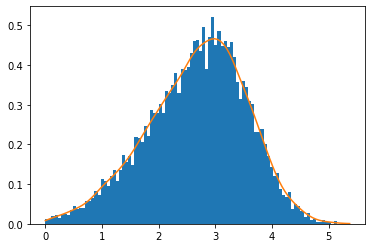

Histogram for F Test feature  1


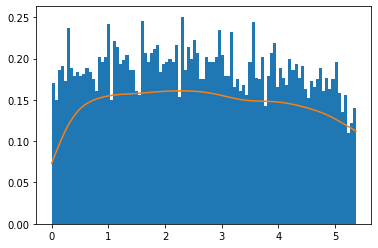

Histogram for F Test feature  2


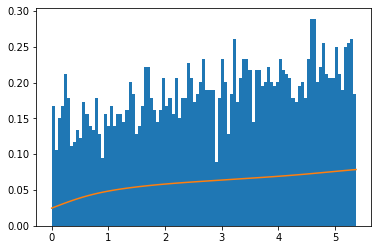

Histogram for F Test feature  3


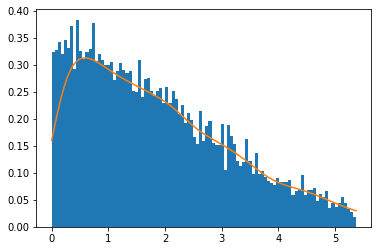

Histogram for F Test feature  4


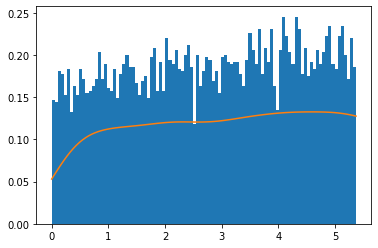

Histogram for F Test feature  5


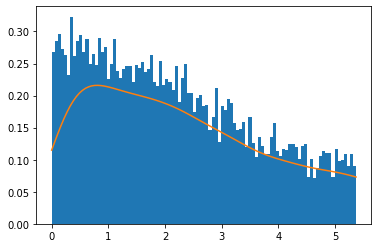

Histogram for F Test feature  6


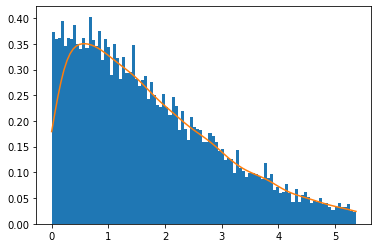

Histogram for F Test feature  7


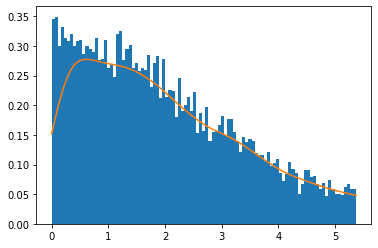

Histogram for F Test feature  8


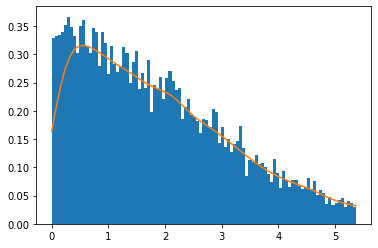

Histogram for F Test feature  9


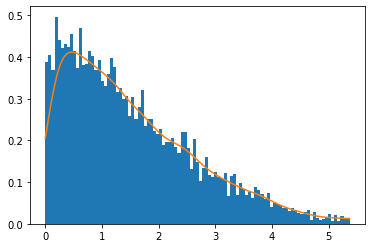

Histogram for F Test feature  10


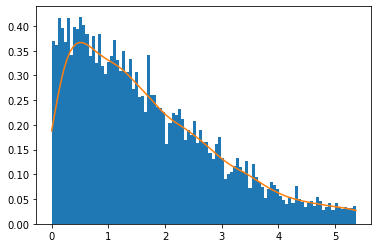

Histogram for F Test feature  11


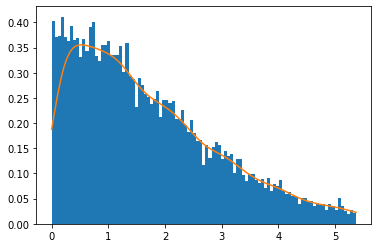

Histogram for F Test feature  12


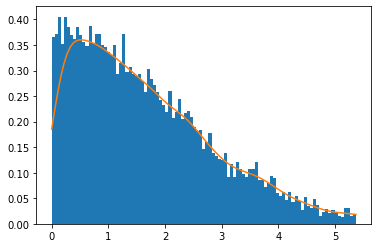

Histogram for F Test feature  13


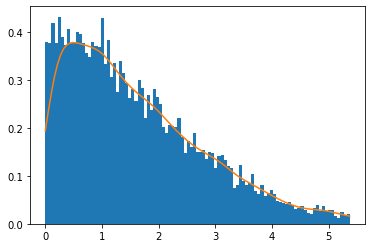

Histogram for F Test feature  14


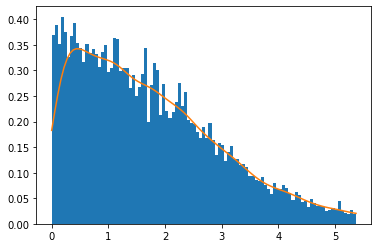

Histogram for F Test feature  15


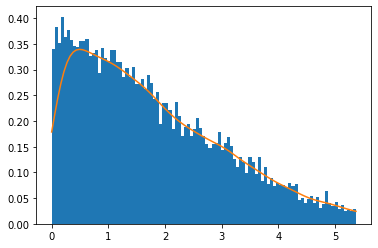

Histogram for F Test feature  16


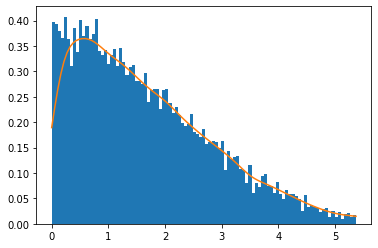

Histogram for F Test feature  17


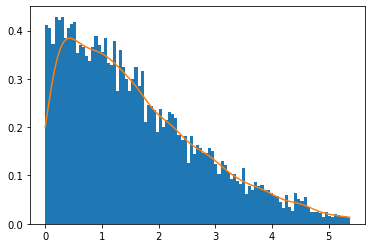

Histogram for F Test feature  18


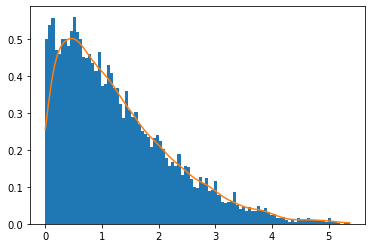

Histogram for F Test feature  19


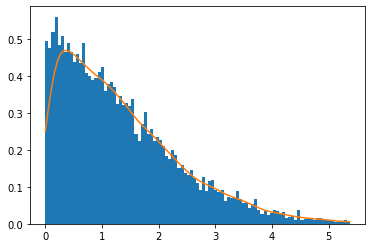

Histogram for F Test feature  20


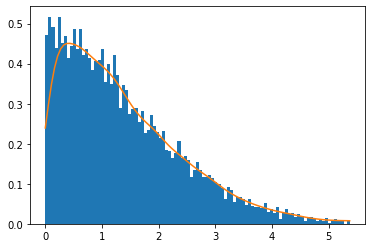

Histogram for F Test feature  21


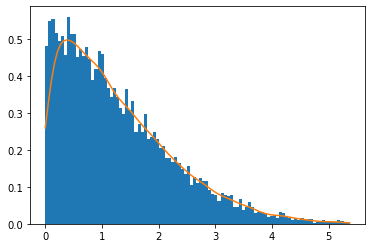

Histogram for F Test feature  22


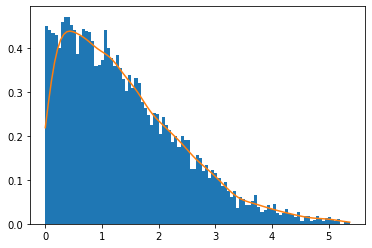

Histogram for F Test feature  23


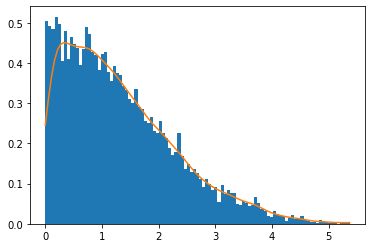

Histogram for F Test feature  24


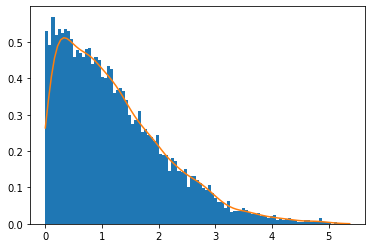

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5544
LR Accuracy on test data - All features:  0.3086
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.553
Logistic Regression Accuracy on test data - rotated:  0.3094
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5499
Logistic Regression Accuracy on test data - rotated:  0.3195
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5464
Logistic Regression Accuracy on test data - rotated:  0.33
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5397
Logistic Regression Accuracy on test data - rotated:  0.2802
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5523
Logistic Regression Accuracy on test data - rotated:  0.2949
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5398
Logistic Regression Accuracy on test data - rotated:  0.2906
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5463
Logistic Regression Accuracy on test data - rotated:  0.2941
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5483
Logistic Regression Accuracy on test data - rotated:  0.2476
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.546
Logistic Regression Accuracy on test data - rotated:  0.3103
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5429
Logistic Regression Accuracy on test data - rotated:  0.2989
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5423
Logistic Regression Accuracy on test data - rotated:  0.2762
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5458
Logistic Regression Accuracy on test data - rotated:  0.2776
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5439
Logistic Regression Accuracy on test data - rotated:  0.3015
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5428
Logistic Regression Accuracy on test data - rotated:  0.3128
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5505
Logistic Regression Accuracy on test data - rotated:  0.2959
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5455
Logistic Regression Accuracy on test data - rotated:  0.3081
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5467
Logistic Regression Accuracy on test data - rotated:  0.2939
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5469
Logistic Regression Accuracy on test data - rotated:  0.3094
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5472
Logistic Regression Accuracy on test data - rotated:  0.2828
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5471
Logistic Regression Accuracy on test data - rotated:  0.2917
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5482
Logistic Regression Accuracy on test data - rotated:  0.3092
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5485
Logistic Regression Accuracy on test data - rotated:  0.3014
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5512
Logistic Regression Accuracy on test data - rotated:  0.3074
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5468
Logistic Regression Accuracy on test data - rotated:  0.3151
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5467
Logistic Regression Accuracy on test data - rotated:  0.3039




Results for lamda  10

Printing eigenvalues
(512,)
[-1.96978221e+01 -8.37546275e+00 -4.37944437e+00 -3.15040895e+00
 -2.24720615e+00 -1.00235821e+00 -7.49789232e-01 -5.20502815e-01
 -1.50844672e-01 -1.23598234e-01 -1.38081979e-07  1.05131259e-02
  8.84662541e-02  1.07015235e-01  1.29455255e-01  1.40983029e-01
  1.43468813e-01  1.48382949e-01  1.54691923e-01  1.60426655e-01
  1.72445171e-01  1.79971290e-01  1.85839708e-01  1.90334162e-01
  1.92939487e-01  2.00268322e-01  2.15399865e-01  2.31503868e-01
  2.31880701e-01  2.39909321e-01  2.43971825e-01  2.48867848e-01
  2.60601393e-01  2.62877450e-01  2.66154333e-01  2.67727394e-01
  2.72694443e-01  2.77640828e-01  2.80810455e-01  2.86756224e-01
  2.87645965e-01  2.92901612e-01  2.95525686e-01  3.01740947e-01
  3.03987888e-01  3.07351059e-01  3.09268246e-01  3.13856067e-01
  3.18939442e-01  3.24907541e-0

(512, 512)

array([[-0.01044171,  0.01936089, -0.03275259, ...,  0.03162839,
        -0.02122812,  0.05135706],
       [ 0.01816249,  0.15142427,  0.01771577, ...,  0.01267484,
        -0.01628556,  0.1008541 ],
       [-0.07409441,  0.04125351,  0.01207974, ..., -0.07604879,
        -0.12671398,  0.11115381],
       ...,
       [-0.00343298, -0.05446224,  0.03893995, ...,  0.01323879,
         0.00739234,  0.03148723],
       [-0.02266925, -0.08976381,  0.00081221, ...,  0.04761021,
        -0.06726187,  0.03893911],
       [-0.0122753 ,  0.00201904, -0.00868805, ..., -0.01214035,
         0.02575079,  0.00929608]])

Printing least k eigenvalues before removing the zero eigenvalue
[-1.96978221e+01 -8.37546275e+00 -4.37944437e+00 -3.15040895e+00
 -2.24720615e+00 -1.00235821e+00 -7.49789232e-01 -5.20502815e-01
 -1.50844672e-01 -1.23598234e-01  0.00000000e+00  1.05131259e-02
  8.84662541e-02  1.07015235e-01  1.29455255e-01  1.40983029e-01
  1.43468813e-01  1.48382949e-01  1.54691923e-01  1.60426655e-01
  1.72445171e-01  1.79971290e-01  1.85839708e-01  1.90334162e-01
  1.92939487e-01]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-1.96978221e+01 -8.37546275e+00 -4.37944437e+00 -3.15040895e+00
 -2.24720615e+00 -1.00235821e+00 -7.49789232e-01 -5.20502815e-01
 -1.50844672e-01 -1.23598234e-01  1.05131259e-02  8.84662541e-02
  1.07015235e-01  1.29455255e-01  1.40983029e-01  1.43468813e-01
  1.48382949e-01  1.54691923e-01  1.60426655e-01  1.72445171e-01
  1.79971290e-01  1.85839708e-01  1.90334162e-01  1.92939487e-01]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014024,1.871142,4.189862,4.193725,1.067406,1.770797,0.761558,0.320919,2.287698,0.586333,...,0.161252,0.285062,0.174100,0.053559,0.011765,0.448319,0.037995,0.571642,0.356572,0.094318
1,2.435493,3.576160,2.388041,8.311271,0.152218,2.983373,0.676249,1.323181,2.800481,0.888682,...,0.243341,0.000250,0.076684,0.152898,0.675845,0.106254,0.164903,0.376171,0.160035,0.059693
2,3.148465,3.718378,3.458856,6.846503,1.989351,4.450737,1.796961,4.140529,0.900676,0.130909,...,0.121870,0.047206,0.241778,0.180578,0.413482,0.501651,0.272809,0.282889,0.202052,0.542248
3,3.554349,3.274287,5.432168,6.744862,0.809285,0.254583,0.724394,0.660796,0.673468,0.029156,...,0.352034,0.297552,0.170583,0.327352,0.600431,0.267132,0.277642,0.208851,0.154671,0.573848
4,2.496240,1.581160,4.943502,2.451188,1.732627,1.208895,1.810507,0.118418,1.860242,0.056878,...,0.470835,0.087332,0.169426,0.026432,0.911242,0.038152,0.173994,0.713556,0.770260,0.243451


Histogram for F Test feature  0


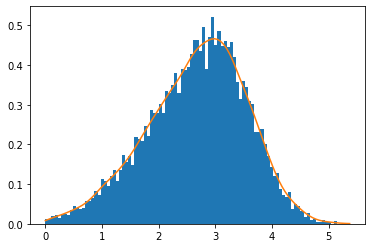

Histogram for F Test feature  1


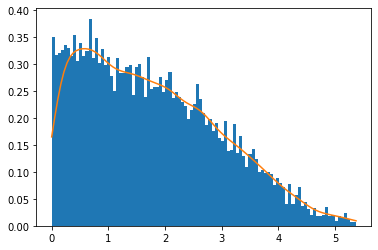

Histogram for F Test feature  2


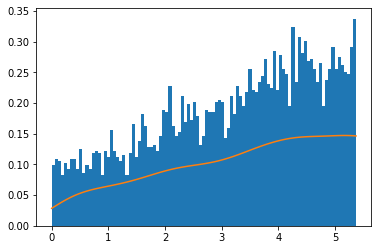

Histogram for F Test feature  3


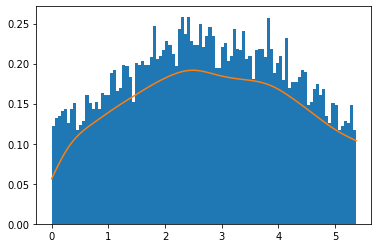

Histogram for F Test feature  4


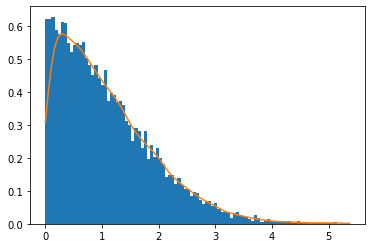

Histogram for F Test feature  5


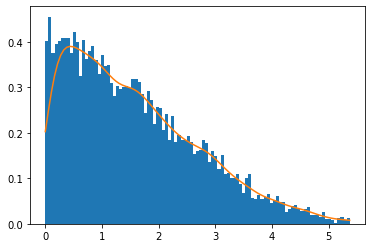

Histogram for F Test feature  6


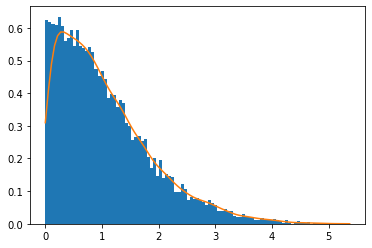

Histogram for F Test feature  7


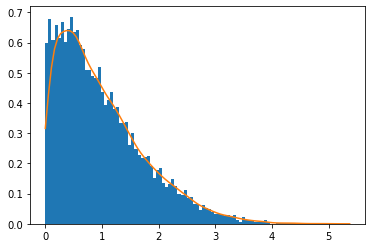

Histogram for F Test feature  8


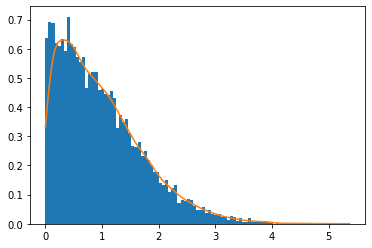

Histogram for F Test feature  9


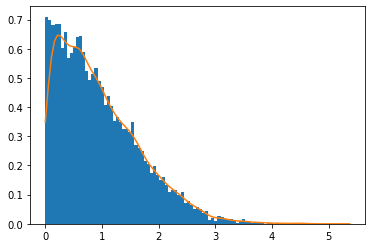

Histogram for F Test feature  10


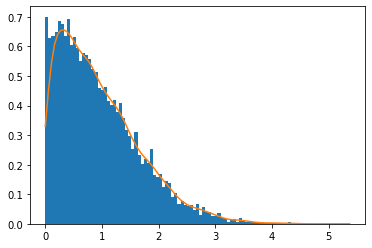

Histogram for F Test feature  11


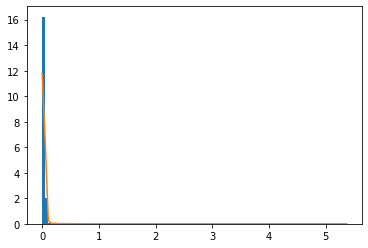

Histogram for F Test feature  12


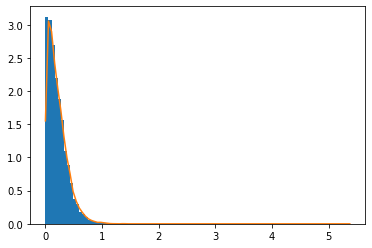

Histogram for F Test feature  13


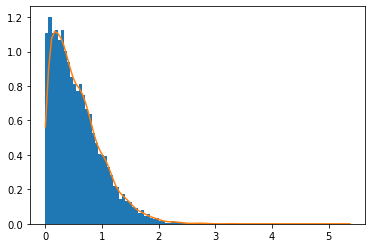

Histogram for F Test feature  14


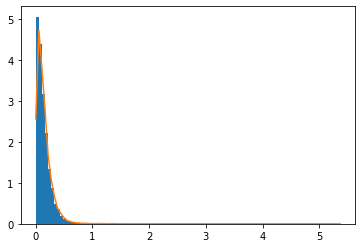

Histogram for F Test feature  15


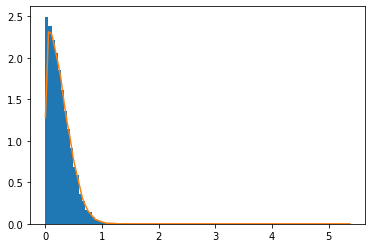

Histogram for F Test feature  16


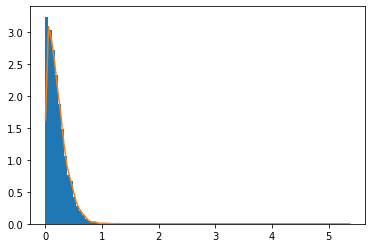

Histogram for F Test feature  17


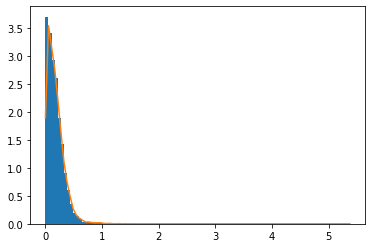

Histogram for F Test feature  18


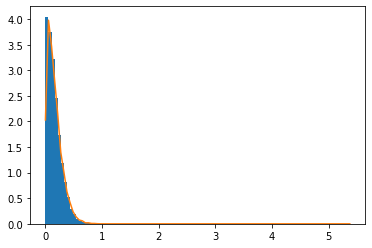

Histogram for F Test feature  19


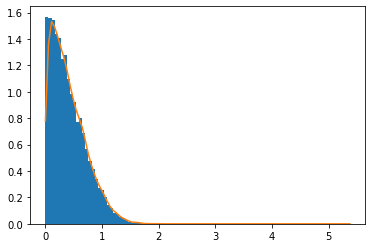

Histogram for F Test feature  20


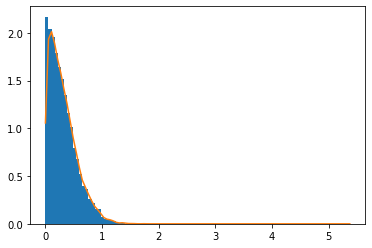

Histogram for F Test feature  21


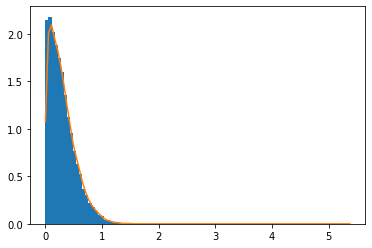

Histogram for F Test feature  22


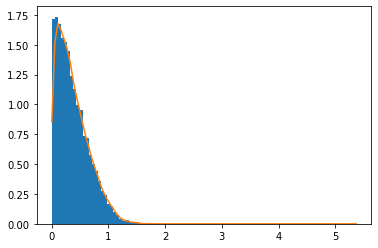

Histogram for F Test feature  23


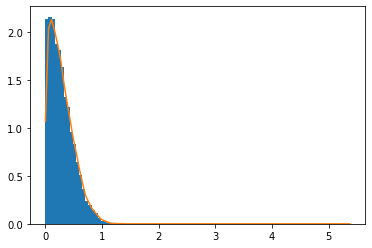

Histogram for F Test feature  24


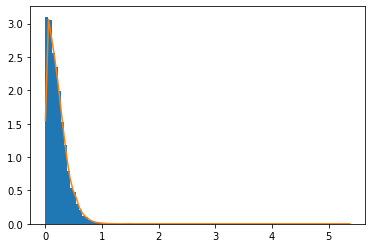

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5193
LR Accuracy on test data - All features:  0.2868
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5186
Logistic Regression Accuracy on test data - rotated:  0.2881
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5142
Logistic Regression Accuracy on test data - rotated:  0.2843
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5106
Logistic Regression Accuracy on test data - rotated:  0.286
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5004
Logistic Regression Accuracy on test data - rotated:  0.2856
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5124
Logistic Regression Accuracy on test data - rotated:  0.2655
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5028
Logistic Regression Accuracy on test data - rotated:  0.2636
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.4998
Logistic Regression Accuracy on test data - rotated:  0.2617
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5101
Logistic Regression Accuracy on test data - rotated:  0.2499
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5135
Logistic Regression Accuracy on test data - rotated:  0.2788
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5086
Logistic Regression Accuracy on test data - rotated:  0.2837
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5105
Logistic Regression Accuracy on test data - rotated:  0.2824
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5188
Logistic Regression Accuracy on test data - rotated:  0.2864
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5189
Logistic Regression Accuracy on test data - rotated:  0.2883
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5169
Logistic Regression Accuracy on test data - rotated:  0.2904
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5184
Logistic Regression Accuracy on test data - rotated:  0.288
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5176
Logistic Regression Accuracy on test data - rotated:  0.2881
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5165
Logistic Regression Accuracy on test data - rotated:  0.2884
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5183
Logistic Regression Accuracy on test data - rotated:  0.2875
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.516
Logistic Regression Accuracy on test data - rotated:  0.2859
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5177
Logistic Regression Accuracy on test data - rotated:  0.2868
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5164
Logistic Regression Accuracy on test data - rotated:  0.2859
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5155
Logistic Regression Accuracy on test data - rotated:  0.2822
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.515
Logistic Regression Accuracy on test data - rotated:  0.2848
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5167
Logistic Regression Accuracy on test data - rotated:  0.2853
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5177
Logistic Regression Accuracy on test data - rotated:  0.2866




Results for lamda  100

Printing eigenvalues
(512,)
[-1.40402524e-06  1.12506043e-01  9.65756718e-01  1.37396122e+00
  1.50867883e+00  1.54492050e+00  1.56841122e+00  1.67948063e+00
  1.75775506e+00  1.90210794e+00  1.96791344e+00  2.01466870e+00
  2.06141899e+00  2.11329019e+00  2.25004341e+00  2.38983058e+00
  2.50119681e+00  2.55460725e+00  2.59515895e+00  2.73046242e+00
  2.77180826e+00  2.85732299e+00  2.88232889e+00  2.93043559e+00
  2.97284557e+00  3.03837973e+00  3.08802997e+00  3.13599580e+00
  3.14559352e+00  3.19008686e+00  3.22853418e+00  3.29903086e+00
  3.32691418e+00  3.36495570e+00  3.37019278e+00  3.41971215e+00
  3.51126591e+00  3.53648382e+00  3.55022513e+00  3.58688450e+00
  3.65716486e+00  3.66906227e+00  3.68585531e+00  3.74184833e+00
  3.75163290e+00  3.80160226e+00  3.82661259e+00  3.87125027e+00
  3.90335604e+00  3.96744228e+

(512, 512)

array([[ 5.30512632e-02, -2.12596366e-03,  1.78129988e-04, ...,
        -2.81002757e-02,  2.57328921e-02,  5.11485303e-02],
       [ 9.86065924e-03, -5.22122013e-04, -6.17821410e-04, ...,
        -2.24764358e-02,  2.16442313e-02,  1.03230162e-01],
       [-2.56526727e-02, -4.16410668e-05,  3.22013786e-03, ...,
         9.65963256e-02,  1.12411334e-01,  1.08715578e-01],
       ...,
       [ 7.37834574e-03, -2.65482013e-04,  3.61102452e-04, ...,
        -1.77779134e-02, -1.11512654e-02,  3.09991792e-02],
       [-4.95922206e-02,  4.52766370e-04,  1.87499145e-03, ...,
        -3.07296408e-02,  5.45612399e-02,  3.68766175e-02],
       [ 1.84950342e-02, -1.37380081e-02, -6.17458355e-03, ...,
         6.08323592e-03, -2.33161814e-02,  9.05015138e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-1.40402524e-06  1.12506043e-01  9.65756718e-01  1.37396122e+00
  1.50867883e+00  1.54492050e+00  1.56841122e+00  1.67948063e+00
  1.75775506e+00  1.90210794e+00  1.96791344e+00  2.01466870e+00
  2.06141899e+00  2.11329019e+00  2.25004341e+00  2.38983058e+00
  2.50119681e+00  2.55460725e+00  2.59515895e+00  2.73046242e+00
  2.77180826e+00  2.85732299e+00  2.88232889e+00  2.93043559e+00
  2.97284557e+00]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-1.40402524e-06  1.12506043e-01  9.65756718e-01  1.37396122e+00
  1.50867883e+00  1.54492050e+00  1.56841122e+00  1.67948063e+00
  1.75775506e+00  1.90210794e+00  1.96791344e+00  2.01466870e+00
  2.06141899e+00  2.11329019e+00  2.25004341e+00  2.38983058e+00
  2.50119681e+00  2.55460725e+00  2.59515895e+00  2.73046242e+00
  2.77180826e+00  2.85732299e+00  2.88232889e+00  2.93043559e+00]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,13886.800185,13883.786160,0.004951,0.019383,0.009461,0.012055,0.104447,0.224733,0.055167,0.001564,...,0.076440,0.009893,0.074355,0.122076,0.341348,0.057910,0.090587,0.499725,0.059992,0.045067
1,234846.849078,234849.284573,0.062289,0.786257,0.170467,0.021432,0.218936,0.190611,0.218814,0.187795,...,0.403801,0.275112,0.320929,0.148684,0.019554,0.129142,0.111710,0.460989,0.431100,0.554291
2,320476.184297,320479.332762,0.094693,0.045017,0.104661,0.368839,0.047105,0.002098,0.276309,0.018405,...,0.147988,0.058092,0.465524,0.224392,0.087438,0.501794,0.091746,0.367940,0.118058,0.064586
3,34354.516373,34350.962024,0.011528,0.042317,0.132332,0.079855,0.122823,0.070711,0.289032,0.027919,...,0.040027,0.096462,0.023561,0.545203,0.426746,0.226779,0.188433,0.297427,0.200975,0.224412
4,426036.002096,426033.505855,0.171614,0.098081,0.234237,0.138533,0.137208,0.087818,0.240655,0.177731,...,0.175856,0.262224,0.099655,0.041805,0.092430,0.543613,0.252009,0.270334,0.020850,0.236968


Histogram for F Test feature  0


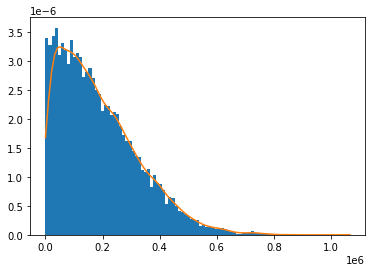

Histogram for F Test feature  1


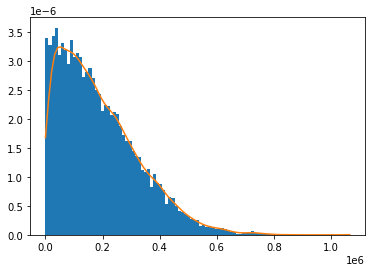

Histogram for F Test feature  2


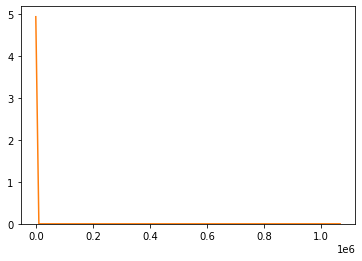

Histogram for F Test feature  3


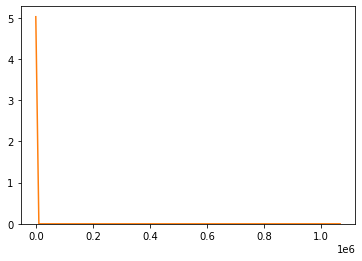

Histogram for F Test feature  4


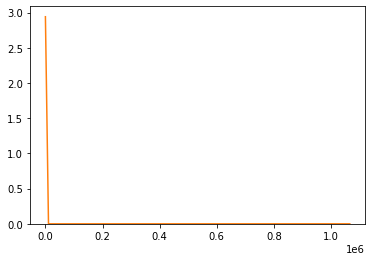

Histogram for F Test feature  5


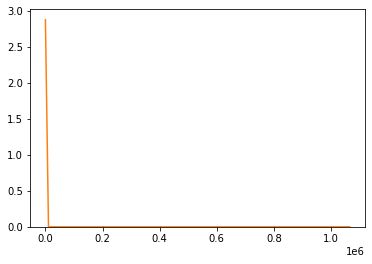

Histogram for F Test feature  6


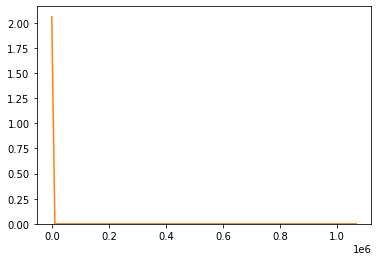

Histogram for F Test feature  7


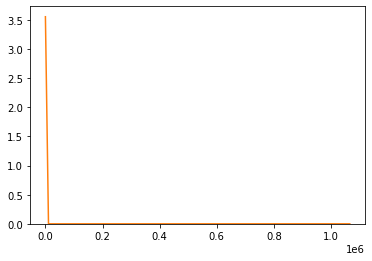

Histogram for F Test feature  8


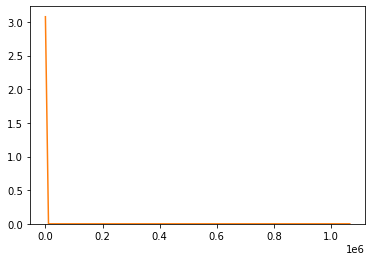

Histogram for F Test feature  9


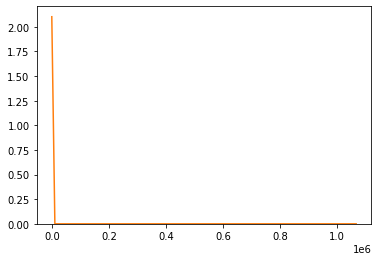

Histogram for F Test feature  10


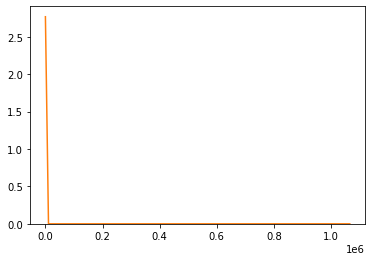

Histogram for F Test feature  11


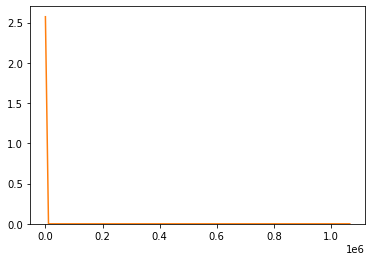

Histogram for F Test feature  12


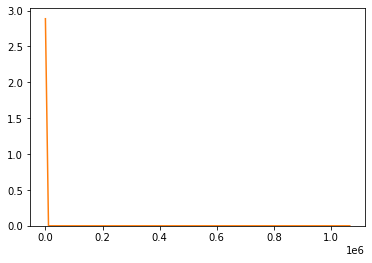

Histogram for F Test feature  13


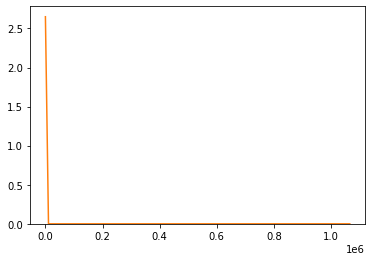

Histogram for F Test feature  14


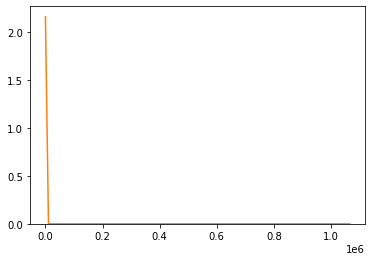

Histogram for F Test feature  15


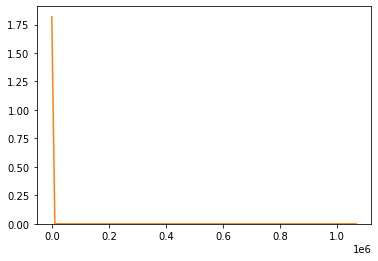

Histogram for F Test feature  16


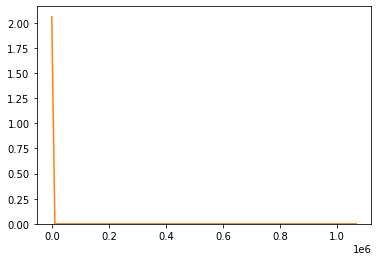

Histogram for F Test feature  17


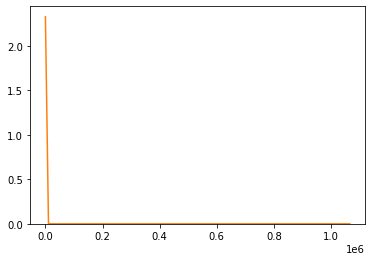

Histogram for F Test feature  18


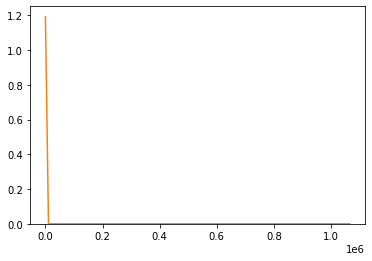

Histogram for F Test feature  19


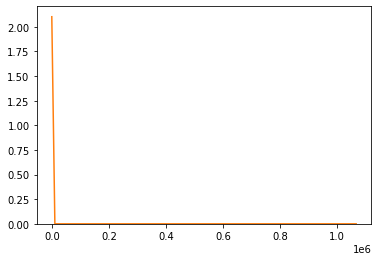

Histogram for F Test feature  20


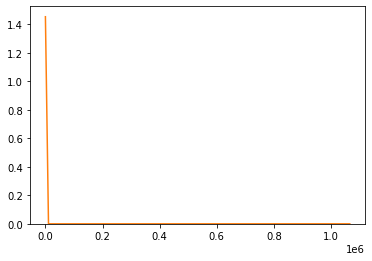

Histogram for F Test feature  21


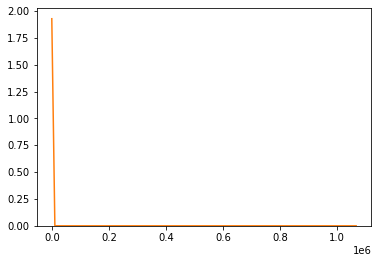

Histogram for F Test feature  22


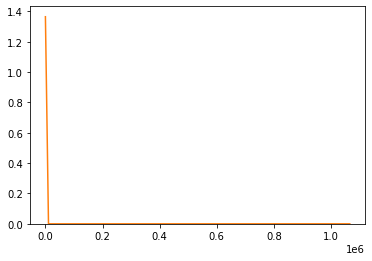

Histogram for F Test feature  23


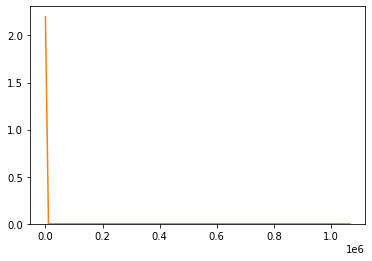

Histogram for F Test feature  24


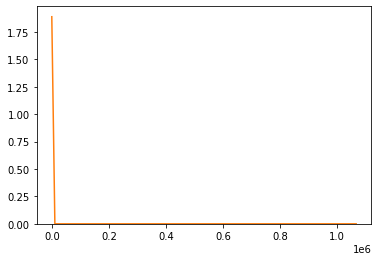

LR Accuracy within training data - All features :  0.1147
LR Accuracy on test data - All features:  0.1026
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.1147
Logistic Regression Accuracy on test data - rotated:  0.1026
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.1147
Logistic Regression Accuracy on test data - rotated:  0.1026
Accuracy for without feature  2
Logistic Regression Accuracy within training data - not rotated:  0.1147
Logistic Regression Accuracy on test data - rotated:  0.1026
Accuracy for without feature  3
Logistic Regression Accuracy within training data - not rotated:  0.1147
Logistic Regression Accuracy on test data - rotated:  0.1026
Accuracy for without feature  4
Logistic Regression Accuracy within training data - not rotated:  0.1147
Logistic Regression Accuracy on test data - rotated:  0.1026
Accuracy for without feature  5
Logistic Regression Accuracy wi

(512, 512)

array([[ 5.30512921e-02, -1.98527566e-03,  1.06166394e-04, ...,
        -2.77875372e-02,  2.59989516e-02,  5.11264991e-02],
       [ 9.86052801e-03, -5.11980022e-04,  7.13424510e-04, ...,
        -2.29143232e-02,  2.21424583e-02,  1.03441804e-01],
       [-2.56525616e-02,  9.09300355e-05, -2.80312339e-03, ...,
         9.83798779e-02,  1.11371388e-01,  1.08486620e-01],
       ...,
       [ 7.37835943e-03, -2.05330487e-04, -1.29033792e-04, ...,
        -1.82545040e-02, -1.15007564e-02,  3.09541456e-02],
       [-4.95922871e-02,  5.40196200e-04, -1.67826200e-03, ...,
        -2.95944874e-02,  5.30732720e-02,  3.66879087e-02],
       [ 1.84950013e-02, -1.39355742e-02,  5.52342043e-03, ...,
         5.53194307e-03, -2.29719926e-02,  9.02734858e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[1.00647373e-05 1.13438711e+00 9.72942037e+00 1.38550929e+01
 1.52079233e+01 1.55909008e+01 1.58145178e+01 1.69320995e+01
 1.77493994e+01 1.92637481e+01 1.98714255e+01 2.03133423e+01
 2.07845205e+01 2.14004770e+01 2.30235027e+01 2.41219313e+01
 2.52118508e+01 2.58637543e+01 2.62915432e+01 2.78604006e+01
 2.83091791e+01 2.90415124e+01 2.92327978e+01 2.96919434e+01
 3.04599156e+01]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[1.00647373e-05 1.13438711e+00 9.72942037e+00 1.38550929e+01
 1.52079233e+01 1.55909008e+01 1.58145178e+01 1.69320995e+01
 1.77493994e+01 1.92637481e+01 1.98714255e+01 2.03133423e+01
 2.07845205e+01 2.14004770e+01 2.30235027e+01 2.41219313e+01
 2.52118508e+01 2.58637543e+01 2.62915432e+01 2.78604006e+01
 2.83091791e+01 2.90415124e+01 2.92327978e+01 2.96919434e+01]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,74078.440243,74075.426217,0.001385,0.021945,0.041358,0.006685,0.068812,0.203204,0.055951,0.031618,...,0.001602,0.015832,0.079339,0.129697,0.381928,0.188457,0.288011,0.060885,0.316925,0.056011
1,99746.742375,99744.306880,0.015328,0.822134,0.174097,0.057264,0.236034,0.170071,0.203873,0.207758,...,0.315549,0.279262,0.321040,0.200305,0.022938,0.251417,0.416266,0.384547,0.162495,0.192045
2,247492.730217,247495.878682,0.014771,0.039105,0.103889,0.318025,0.018954,0.027651,0.246101,0.015656,...,0.100023,0.100614,0.515799,0.048056,0.244828,0.312689,0.210589,0.194554,0.232968,0.145080
3,28347.113420,28350.667769,0.002261,0.024324,0.081438,0.083167,0.067102,0.063547,0.286425,0.013878,...,0.036545,0.038985,0.075009,0.504397,0.403868,0.268957,0.039295,0.200314,0.320933,0.088160
4,381029.032428,381026.536187,0.019959,0.100642,0.147025,0.076532,0.041736,0.022845,0.208867,0.081515,...,0.137535,0.248583,0.065985,0.011159,0.137788,0.163301,0.166330,0.036431,0.028437,0.186481


Histogram for F Test feature  0


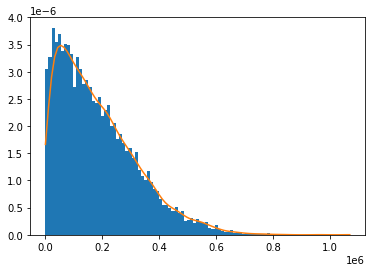

Histogram for F Test feature  1


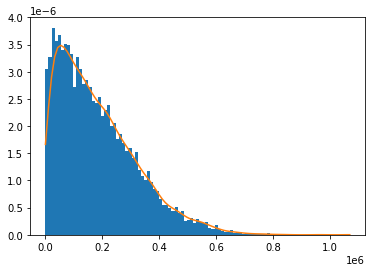

Histogram for F Test feature  2


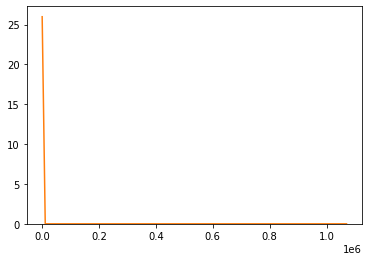

Histogram for F Test feature  3


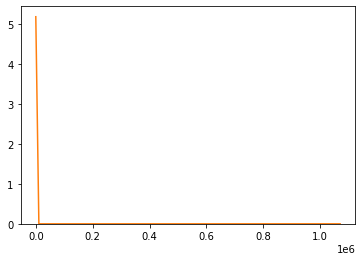

Histogram for F Test feature  4


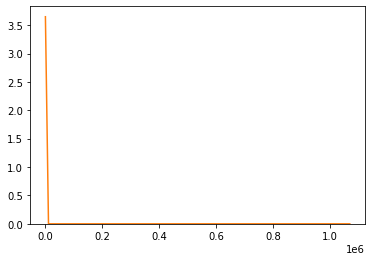

Histogram for F Test feature  5


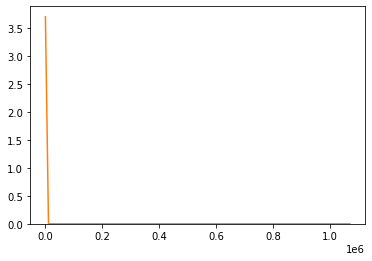

Histogram for F Test feature  6


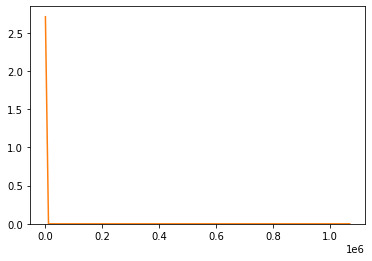

Histogram for F Test feature  7


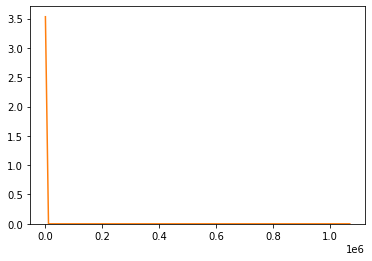

Histogram for F Test feature  8


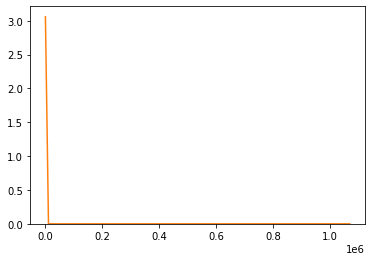

Histogram for F Test feature  9


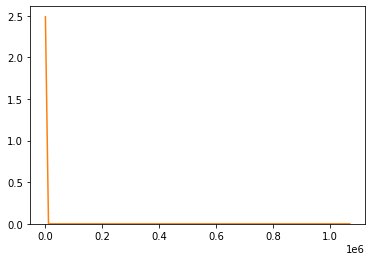

Histogram for F Test feature  10


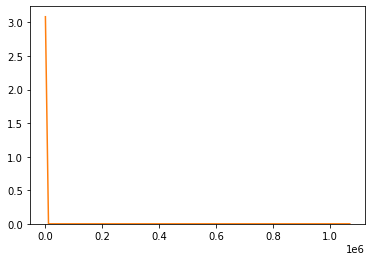

Histogram for F Test feature  11


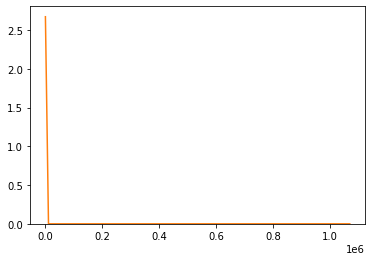

Histogram for F Test feature  12


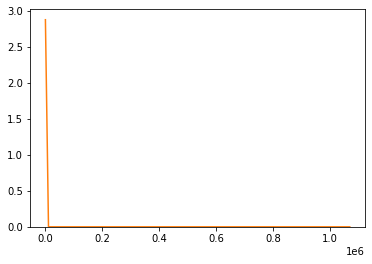

Histogram for F Test feature  13


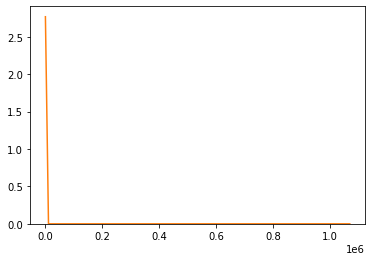

Histogram for F Test feature  14


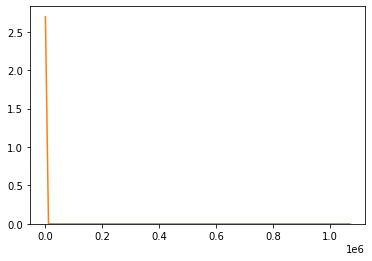

Histogram for F Test feature  15


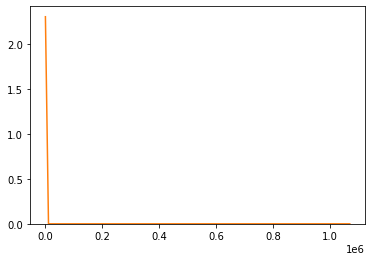

Histogram for F Test feature  16


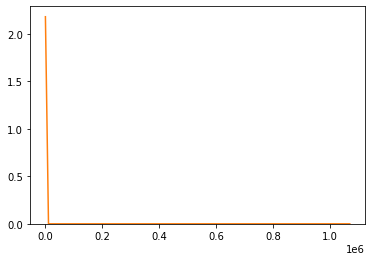

Histogram for F Test feature  17


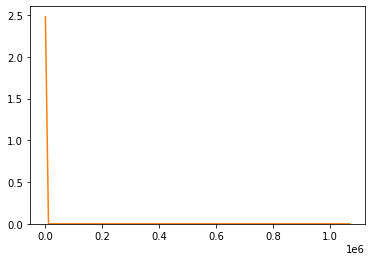

Histogram for F Test feature  18


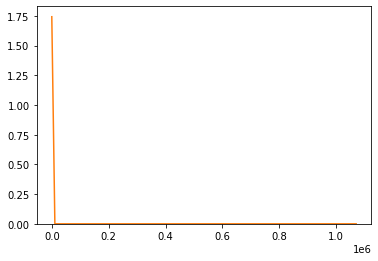

Histogram for F Test feature  19


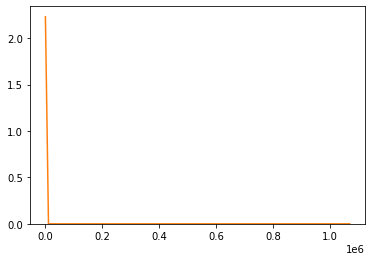

Histogram for F Test feature  20


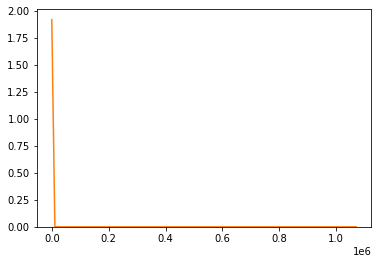

Histogram for F Test feature  21


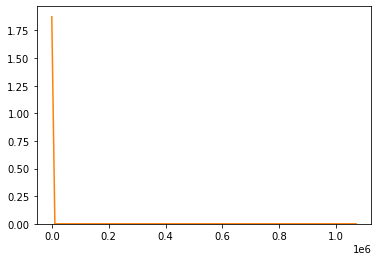

Histogram for F Test feature  22


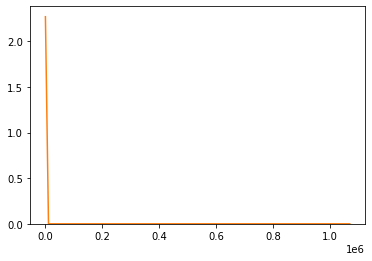

Histogram for F Test feature  23


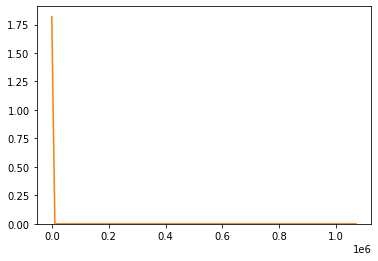

Histogram for F Test feature  24


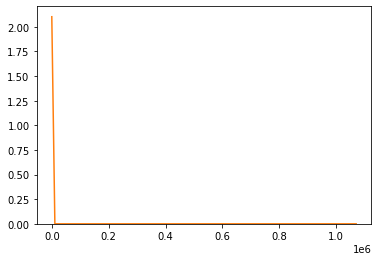

LR Accuracy within training data - All features :  0.1248
LR Accuracy on test data - All features:  0.0999
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.1248
Logistic Regression Accuracy on test data - rotated:  0.0999
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.1248
Logistic Regression Accuracy on test data - rotated:  0.0999
Accuracy for without feature  2
Logistic Regression Accuracy within training data - not rotated:  0.1248
Logistic Regression Accuracy on test data - rotated:  0.0999
Accuracy for without feature  3
Logistic Regression Accuracy within training data - not rotated:  0.1248
Logistic Regression Accuracy on test data - rotated:  0.0999
Accuracy for without feature  4
Logistic Regression Accuracy within training data - not rotated:  0.1248
Logistic Regression Accuracy on test data - rotated:  0.0999
Accuracy for without feature  5
Logistic Regression Accuracy wi

(512, 512)

array([[ 5.30512947e-02, -1.97962131e-03,  9.89578403e-05, ...,
        -2.77564332e-02,  2.60242168e-02,  5.11242871e-02],
       [ 9.86057161e-03, -5.11561701e-04,  7.21452586e-04, ...,
        -2.29502069e-02,  2.21919073e-02,  1.03462732e-01],
       [-2.56525540e-02,  9.60820166e-05, -2.79682131e-03, ...,
         9.85587132e-02,  1.11270963e-01,  1.08463872e-01],
       ...,
       [ 7.37842769e-03, -2.03431757e-04, -1.25923163e-04, ...,
        -1.83023681e-02, -1.15352569e-02,  3.09496783e-02],
       [-4.95923293e-02,  5.43933410e-04, -1.67669959e-03, ...,
        -2.94856853e-02,  5.29242839e-02,  3.66691996e-02],
       [ 1.84949131e-02, -1.39430452e-02,  5.52468183e-03, ...,
         5.47670257e-03, -2.29372011e-02,  9.02508514e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-9.53759504e-05  1.13526889e+01  9.73616343e+01  1.38656342e+02
  1.52193113e+02  1.56032310e+02  1.58269046e+02  1.69453630e+02
  1.77651395e+02  1.92795182e+02  1.98892257e+02  2.03274307e+02
  2.07991121e+02  2.14172598e+02  2.30479572e+02  2.41415227e+02
  2.52310863e+02  2.58890457e+02  2.63119208e+02  2.78827252e+02
  2.83350451e+02  2.90627453e+02  2.92598299e+02  2.97153950e+02
  3.04860545e+02]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-9.53759504e-05  1.13526889e+01  9.73616343e+01  1.38656342e+02
  1.52193113e+02  1.56032310e+02  1.58269046e+02  1.69453630e+02
  1.77651395e+02  1.92795182e+02  1.98892257e+02  2.03274307e+02
  2.07991121e+02  2.14172598e+02  2.30479572e+02  2.41415227e+02
  2.52310863e+02  2.58890457e+02  2.63119208e+02  2.78827252e+02
  2.83350451e+02  2.90627453e+02  2.92598299e+02  2.97153950e+02]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,68873.055030,68876.069055,0.031127,0.005355,0.045651,0.000856,0.054459,0.212580,0.059115,0.029621,...,0.001000,0.016381,0.080783,0.138777,0.413545,0.141444,0.285884,0.049644,0.309207,0.062812
1,390055.868392,390053.432899,0.184877,0.841995,0.182345,0.032431,0.275812,0.190633,0.191612,0.174029,...,0.323528,0.254257,0.253219,0.229729,0.057844,0.310111,0.346578,0.398615,0.210793,0.189938
2,218273.782584,218276.931049,0.081041,0.023439,0.096137,0.277922,0.033751,0.013189,0.261248,0.024842,...,0.075614,0.084895,0.458484,0.078753,0.218151,0.276979,0.147794,0.187027,0.279822,0.128911
3,222840.849133,222844.403483,0.099233,0.008398,0.072650,0.072793,0.038989,0.055104,0.290865,0.033373,...,0.046290,0.048221,0.042546,0.511026,0.431589,0.315000,0.070549,0.211686,0.339985,0.087093
4,362894.462346,362896.958588,0.136745,0.015795,0.132415,0.034837,0.025479,0.073840,0.222389,0.096389,...,0.119525,0.253000,0.057134,0.025404,0.019073,0.071429,0.160820,0.023599,0.053686,0.150211


Histogram for F Test feature  0


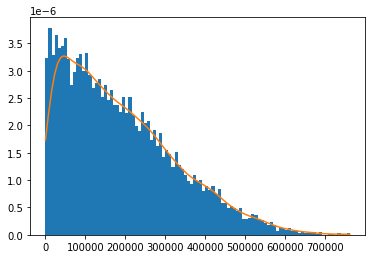

Histogram for F Test feature  1


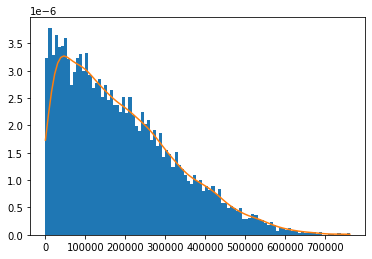

Histogram for F Test feature  2


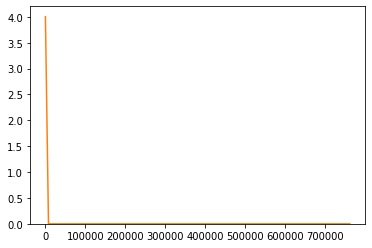

Histogram for F Test feature  3


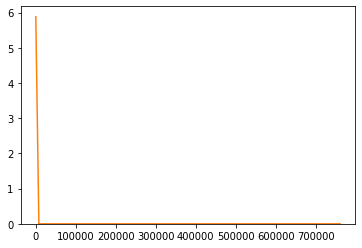

Histogram for F Test feature  4


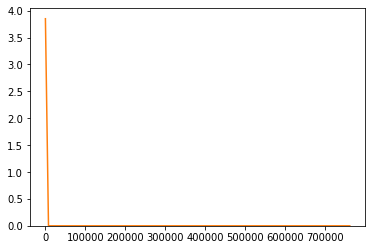

Histogram for F Test feature  5


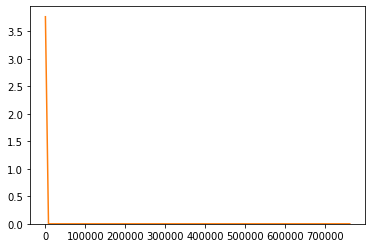

Histogram for F Test feature  6


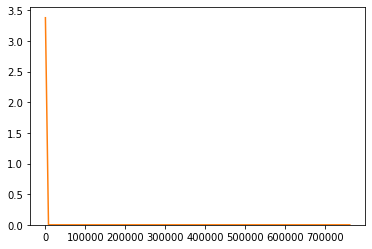

Histogram for F Test feature  7


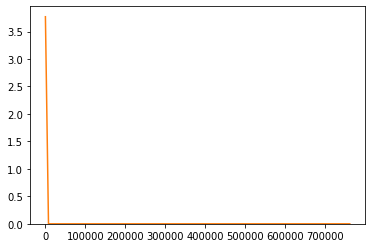

Histogram for F Test feature  8


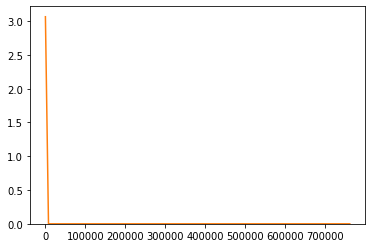

Histogram for F Test feature  9


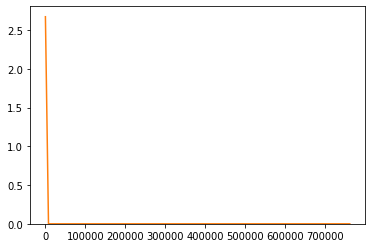

Histogram for F Test feature  10


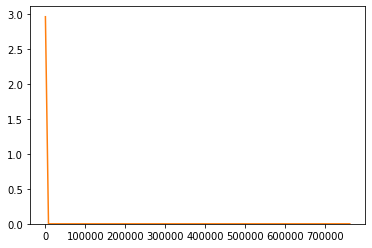

Histogram for F Test feature  11


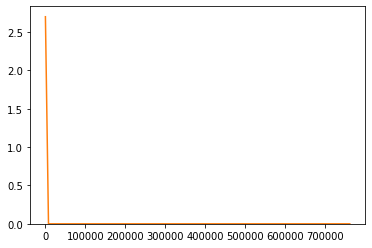

Histogram for F Test feature  12


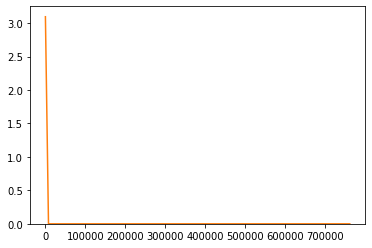

Histogram for F Test feature  13


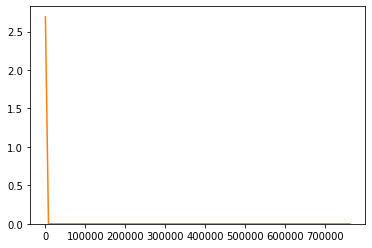

Histogram for F Test feature  14


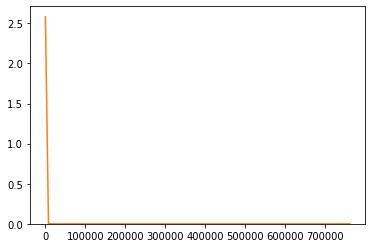

Histogram for F Test feature  15


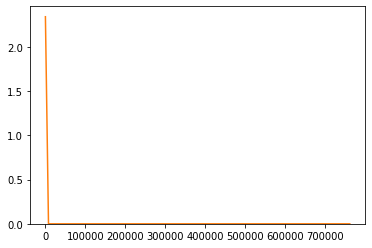

Histogram for F Test feature  16


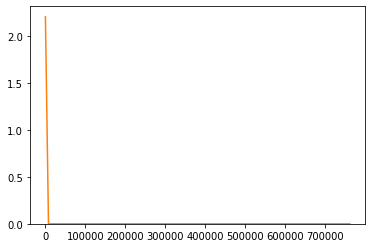

Histogram for F Test feature  17


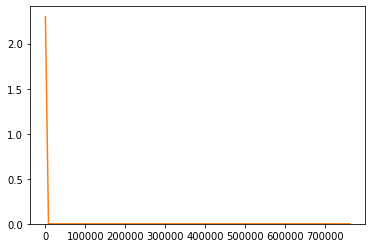

Histogram for F Test feature  18


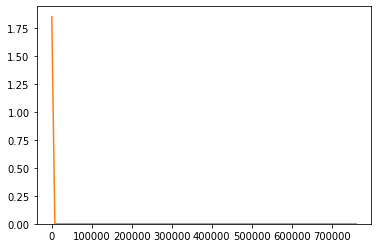

Histogram for F Test feature  19


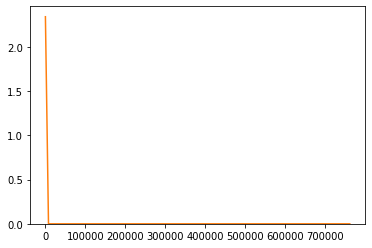

Histogram for F Test feature  20


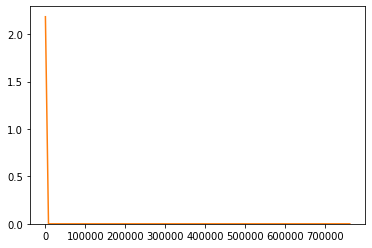

Histogram for F Test feature  21


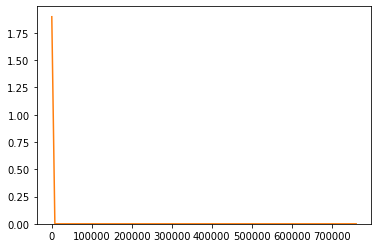

Histogram for F Test feature  22


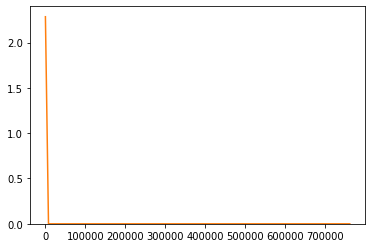

Histogram for F Test feature  23


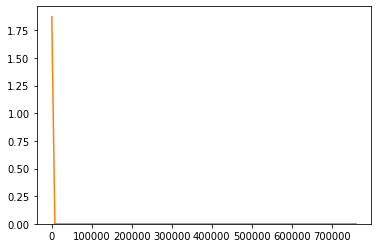

Histogram for F Test feature  24


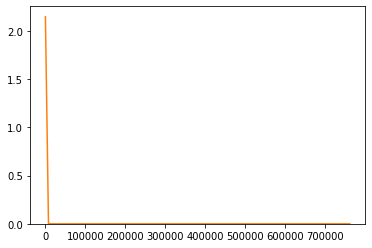

LR Accuracy within training data - All features :  0.1342
LR Accuracy on test data - All features:  0.0968
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.1342
Logistic Regression Accuracy on test data - rotated:  0.0968
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.1342
Logistic Regression Accuracy on test data - rotated:  0.0968
Accuracy for without feature  2
Logistic Regression Accuracy within training data - not rotated:  0.1342
Logistic Regression Accuracy on test data - rotated:  0.0968
Accuracy for without feature  3
Logistic Regression Accuracy within training data - not rotated:  0.1342
Logistic Regression Accuracy on test data - rotated:  0.0968
Accuracy for without feature  4
Logistic Regression Accuracy within training data - not rotated:  0.1342
Logistic Regression Accuracy on test data - rotated:  0.0968
Accuracy for without feature  5
Logistic Regression Accuracy wi

(512, 512)

array([[ 5.30513660e-02, -1.97902367e-03,  9.83056237e-05, ...,
        -2.77533212e-02,  2.60267394e-02,  5.11240667e-02],
       [ 9.86060432e-03, -5.11521598e-04,  7.22304709e-04, ...,
        -2.29537282e-02,  2.21968311e-02,  1.03464822e-01],
       [-2.56525487e-02,  9.65771334e-05, -2.79618422e-03, ...,
         9.85765729e-02,  1.11260930e-01,  1.08461597e-01],
       ...,
       [ 7.37840130e-03, -2.03249583e-04, -1.25559642e-04, ...,
        -1.83071559e-02, -1.15387157e-02,  3.09492315e-02],
       [-4.95922806e-02,  5.44258030e-04, -1.67662157e-03, ...,
        -2.94748432e-02,  5.29093886e-02,  3.66673313e-02],
       [ 1.84949439e-02, -1.39437172e-02,  5.52499776e-03, ...,
         5.47117911e-03, -2.29337204e-02,  9.02485916e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          113.53570607  973.68386327 1386.66822494 1522.04443366
 1560.44557347 1582.81379903 1694.66997431 1776.67004306 1928.1078463
 1989.10111797 2032.88317456 2080.05685679 2141.89407933 2305.03907573
 2414.3493173  2523.29954456 2589.15520923 2631.39412036 2788.49582336
 2833.76100163 2906.48688592 2926.25112455 2971.7732809  3048.86462901]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 113.53570607  973.68386327 1386.66822494 1522.04443366 1560.44557347
 1582.81379903 1694.66997431 1776.67004306 1928.1078463  1989.10111797
 2032.88317456 2080.05685679 2141.89407933 2305.03907573 2414.3493173
 2523.29954456 2589.15520923 2631.39412036 2788.49582336 2833.76100163
 2906.48688592 2926.25112455 2971.7732809  3048.86462901]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,0.001205,0.011345,0.043879,0.002769,0.062673,0.213526,0.060213,0.025372,0.136942,...,0.020083,0.071036,0.141505,0.402696,0.158435,0.276058,0.054068,0.303522,0.061427,0.047020
1,2.435494,0.015381,0.807916,0.171112,0.043540,0.228113,0.184805,0.197458,0.198982,0.192582,...,0.274189,0.308260,0.216083,0.004434,0.212456,0.401190,0.373308,0.180328,0.197489,0.231327
2,3.148465,0.013777,0.004360,0.101988,0.284126,0.007379,0.009958,0.257834,0.011024,0.174276,...,0.096497,0.489465,0.070290,0.183660,0.222572,0.178628,0.173063,0.262103,0.124395,0.131173
3,3.554349,0.002414,0.027814,0.078695,0.079132,0.065876,0.058335,0.287415,0.019425,0.017088,...,0.036434,0.074289,0.502579,0.396033,0.259390,0.038900,0.197303,0.322156,0.091632,0.114308
4,2.496241,0.020911,0.047478,0.142521,0.024462,0.018559,0.079109,0.227914,0.119280,0.010967,...,0.234149,0.108484,0.038820,0.038767,0.018984,0.109553,0.000441,0.082323,0.157299,0.000671


Histogram for F Test feature  0


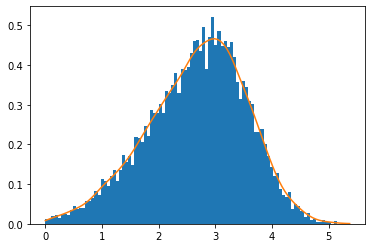

Histogram for F Test feature  1


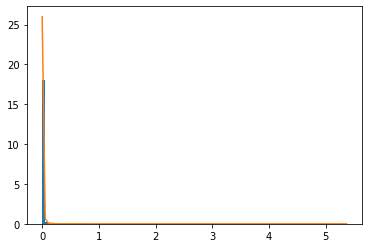

Histogram for F Test feature  2


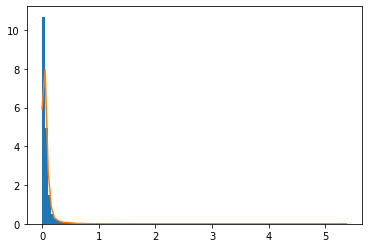

Histogram for F Test feature  3


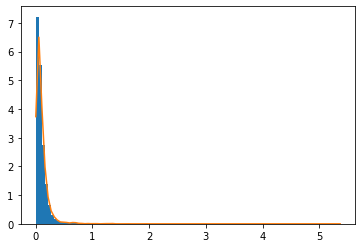

Histogram for F Test feature  4


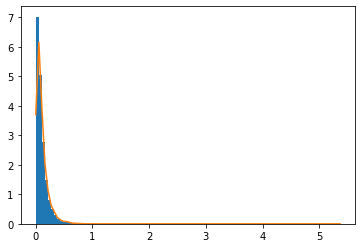

Histogram for F Test feature  5


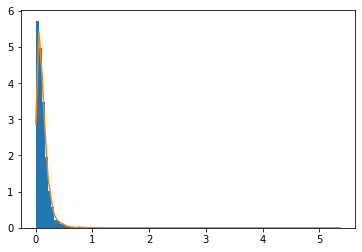

Histogram for F Test feature  6


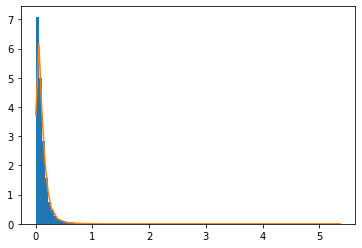

Histogram for F Test feature  7


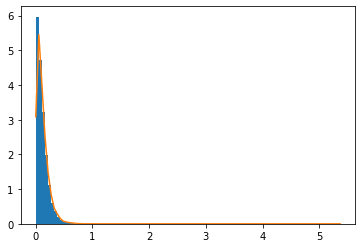

Histogram for F Test feature  8


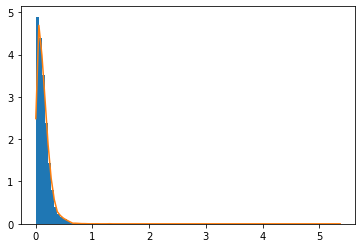

Histogram for F Test feature  9


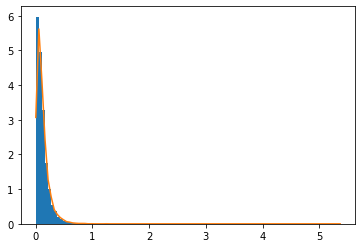

Histogram for F Test feature  10


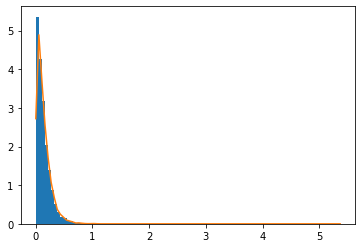

Histogram for F Test feature  11


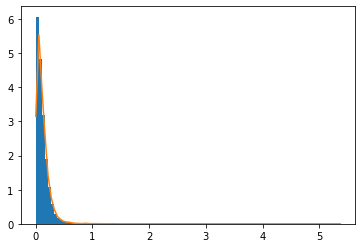

Histogram for F Test feature  12


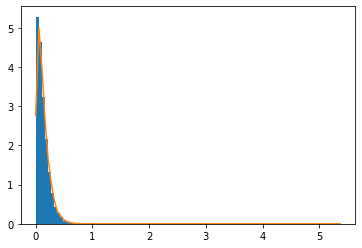

Histogram for F Test feature  13


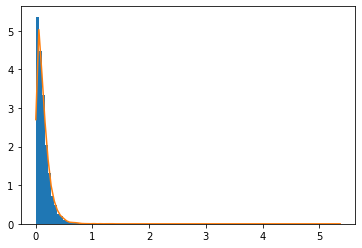

Histogram for F Test feature  14


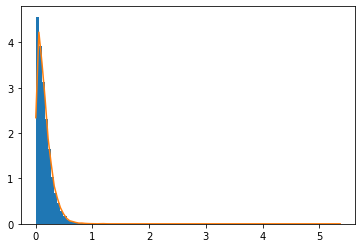

Histogram for F Test feature  15


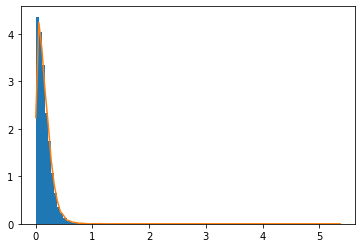

Histogram for F Test feature  16


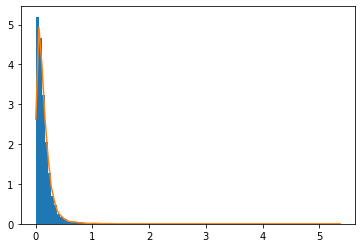

Histogram for F Test feature  17


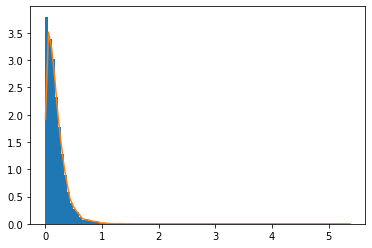

Histogram for F Test feature  18


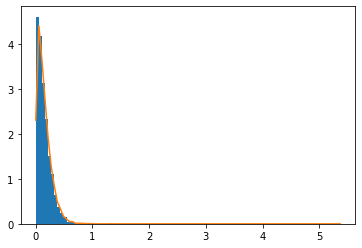

Histogram for F Test feature  19


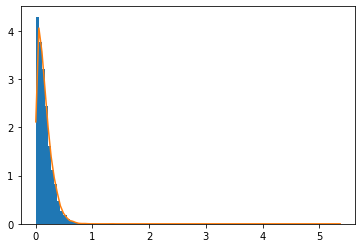

Histogram for F Test feature  20


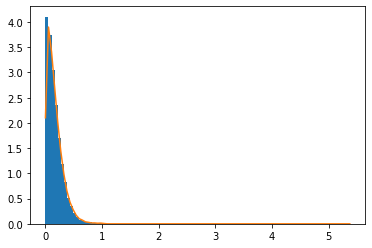

Histogram for F Test feature  21


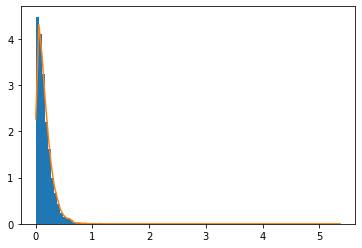

Histogram for F Test feature  22


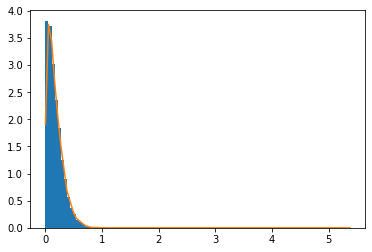

Histogram for F Test feature  23


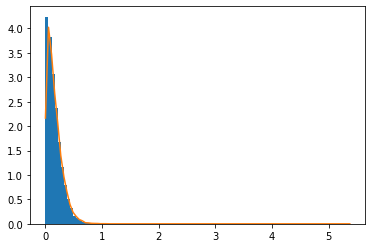

Histogram for F Test feature  24


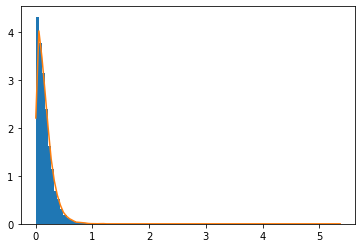

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.287
LR Accuracy on test data - All features:  0.1477
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.2681
Logistic Regression Accuracy on test data - rotated:  0.1491
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.2875
Logistic Regression Accuracy on test data - rotated:  0.1483
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2839
Logistic Regression Accuracy on test data - rotated:  0.1464
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2851
Logistic Regression Accuracy on test data - rotated:  0.1489
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2832
Logistic Regression Accuracy on test data - rotated:  0.1478
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2868
Logistic Regression Accuracy on test data - rotated:  0.1454
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2842
Logistic Regression Accuracy on test data - rotated:  0.1472
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2857
Logistic Regression Accuracy on test data - rotated:  0.1471
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.286
Logistic Regression Accuracy on test data - rotated:  0.1477
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1472
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2787
Logistic Regression Accuracy on test data - rotated:  0.1488
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2824
Logistic Regression Accuracy on test data - rotated:  0.1435
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2841
Logistic Regression Accuracy on test data - rotated:  0.1473
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2848
Logistic Regression Accuracy on test data - rotated:  0.146
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2687
Logistic Regression Accuracy on test data - rotated:  0.1414
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1465
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2854
Logistic Regression Accuracy on test data - rotated:  0.1462
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1437
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2824
Logistic Regression Accuracy on test data - rotated:  0.1462
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2856
Logistic Regression Accuracy on test data - rotated:  0.1472
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2832
Logistic Regression Accuracy on test data - rotated:  0.1478
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2854
Logistic Regression Accuracy on test data - rotated:  0.1468
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2837
Logistic Regression Accuracy on test data - rotated:  0.1433
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.288
Logistic Regression Accuracy on test data - rotated:  0.1473
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2796
Logistic Regression Accuracy on test data - rotated:  0.1466




Results for lamda  1000000

Printing eigenvalues
(512,)
[-1.45130620e-09  1.13536585e+03  9.73690593e+03  1.38667871e+04
  1.52205580e+04  1.56045783e+04  1.58282614e+04  1.69468323e+04
  1.77668568e+04  1.92812347e+04  1.98911887e+04  2.03289720e+04
  2.08007139e+04  2.14191072e+04  2.30506312e+04  2.41436885e+04
  2.52331872e+04  2.58918020e+04  2.63141437e+04  2.78851809e+04
  2.83378654e+04  2.90650807e+04  2.92627787e+04  2.97179664e+04
  3.04889058e+04  3.10659998e+04  3.15226874e+04  3.16509761e+04
  3.19026664e+04  3.23444898e+04  3.27230663e+04  3.34199605e+04
  3.39382199e+04  3.39915052e+04  3.43922396e+04  3.52460052e+04
  3.55185586e+04  3.57432380e+04  3.61686231e+04  3.66691610e+04
  3.70505228e+04  3.71684669e+04  3.74233147e+04  3.78979181e+04
  3.81156354e+04  3.85010513e+04  3.89680902e+04  3.92707486e+04
  4.00509574e+04  4.006855

(512, 512)

array([[ 5.30513660e-02, -1.97896983e-03,  9.82285431e-05, ...,
        -2.77530100e-02,  2.60269908e-02,  5.11240446e-02],
       [ 9.86060432e-03, -5.11517908e-04,  7.22384840e-04, ...,
        -2.29540789e-02,  2.21973250e-02,  1.03465031e-01],
       [-2.56525487e-02,  9.66262859e-05, -2.79612830e-03, ...,
         9.85783620e-02,  1.11259929e-01,  1.08461370e-01],
       ...,
       [ 7.37840130e-03, -2.03231707e-04, -1.25532114e-04, ...,
        -1.83076348e-02, -1.15390604e-02,  3.09491868e-02],
       [-4.95922806e-02,  5.44293024e-04, -1.67661054e-03, ...,
        -2.94737601e-02,  5.29078988e-02,  3.66671444e-02],
       [ 1.84949439e-02, -1.39437877e-02,  5.52502057e-03, ...,
         5.47062654e-03, -2.29333722e-02,  9.02483655e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[    0.          1135.36584846  9736.90593186 13866.78710835
 15220.55797179 15604.57833086 15828.26139183 16946.83228161
 17766.85678696 19281.23468044 19891.18871031 20328.9719823
 20800.71391217 21419.1071738  23050.63122563 24143.68846882
 25233.18723807 25891.8019901  26314.14366869 27885.18086304
 28337.865399   29065.08069605 29262.77868142 29717.96638763
 30488.90575473]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 1135.36584846  9736.90593186 13866.78710835 15220.55797179
 15604.57833086 15828.26139183 16946.83228161 17766.85678696
 19281.23468044 19891.18871031 20328.9719823  20800.71391217
 21419.1071738  23050.63122563 24143.68846882 25233.18723807
 25891.8019901  26314.14366869 27885.18086304 28337.865399
 29065.08069605 29262.77868142 29717.96638763 30488.90575473]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,0.001205,0.011342,0.043896,0.002763,0.062656,0.213518,0.060217,0.025385,0.136928,...,0.020099,0.071036,0.141532,0.402709,0.158412,0.276042,0.054067,0.303497,0.061426,0.047030
1,2.435494,0.015378,0.807913,0.171092,0.043538,0.228093,0.184801,0.197446,0.198996,0.192586,...,0.274174,0.308245,0.216117,0.004446,0.212438,0.401178,0.373289,0.180359,0.197474,0.231290
2,3.148465,0.013775,0.004358,0.101956,0.284124,0.007400,0.009959,0.257826,0.011030,0.174276,...,0.096533,0.489475,0.070227,0.183689,0.222586,0.178649,0.173072,0.262052,0.124375,0.131156
3,3.554349,0.002415,0.027810,0.078669,0.079131,0.065851,0.058326,0.287411,0.019447,0.017094,...,0.036404,0.074310,0.502533,0.396029,0.259398,0.038862,0.197300,0.322132,0.091645,0.114322
4,2.496241,0.020909,0.047478,0.142506,0.024460,0.018543,0.079097,0.227911,0.119261,0.010989,...,0.234132,0.108484,0.038861,0.038768,0.018955,0.109519,0.000460,0.082324,0.157292,0.000664


Histogram for F Test feature  0


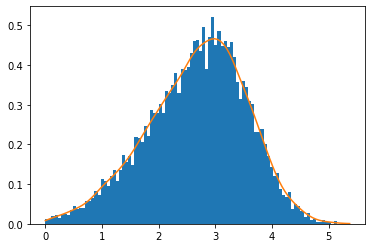

Histogram for F Test feature  1


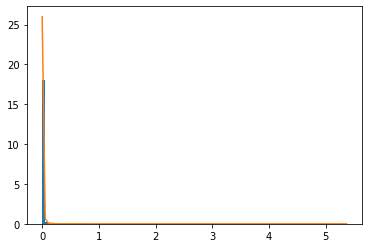

Histogram for F Test feature  2


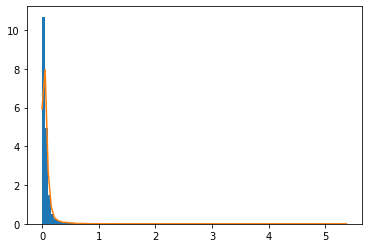

Histogram for F Test feature  3


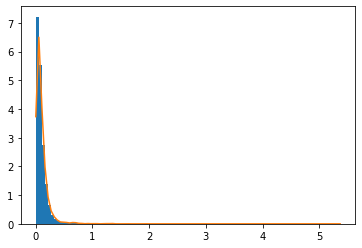

Histogram for F Test feature  4


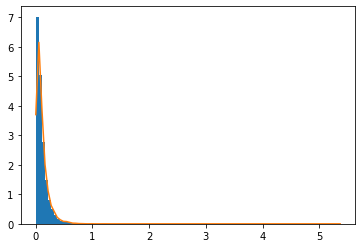

Histogram for F Test feature  5


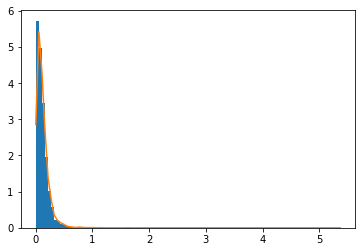

Histogram for F Test feature  6


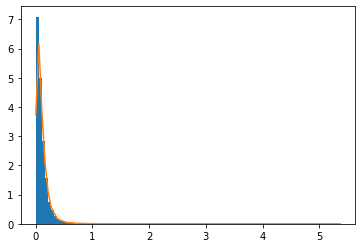

Histogram for F Test feature  7


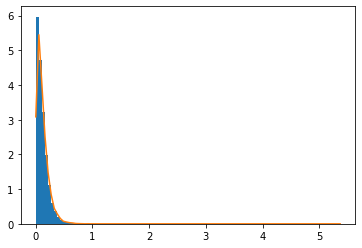

Histogram for F Test feature  8


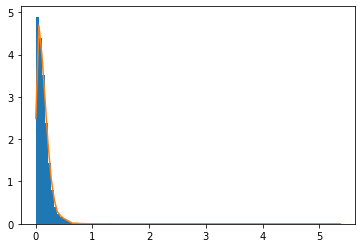

Histogram for F Test feature  9


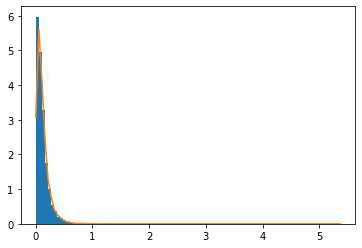

Histogram for F Test feature  10


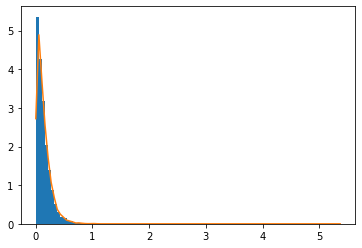

Histogram for F Test feature  11


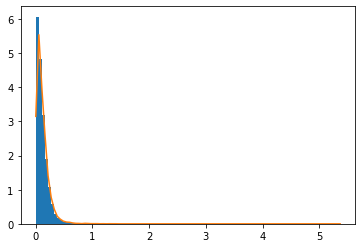

Histogram for F Test feature  12


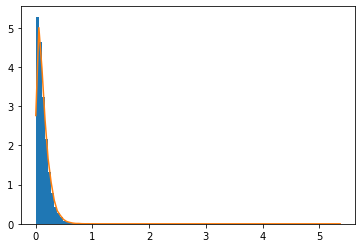

Histogram for F Test feature  13


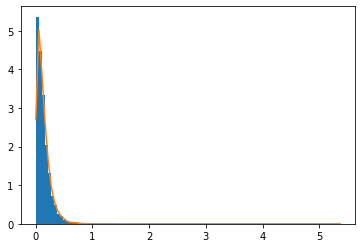

Histogram for F Test feature  14


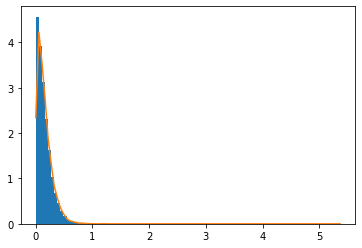

Histogram for F Test feature  15


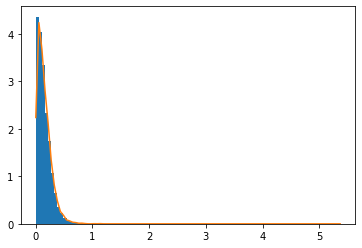

Histogram for F Test feature  16


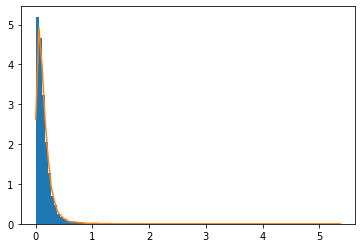

Histogram for F Test feature  17


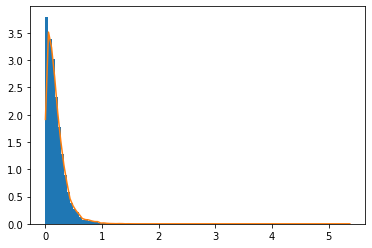

Histogram for F Test feature  18


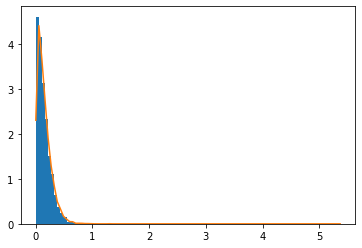

Histogram for F Test feature  19


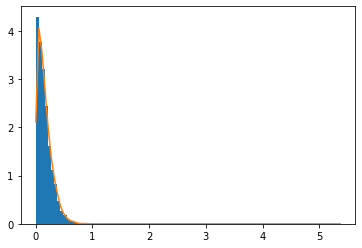

Histogram for F Test feature  20


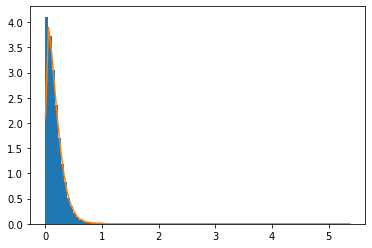

Histogram for F Test feature  21


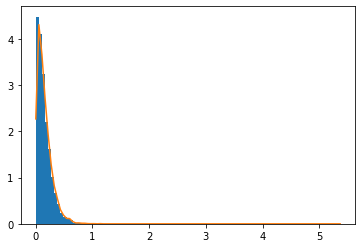

Histogram for F Test feature  22


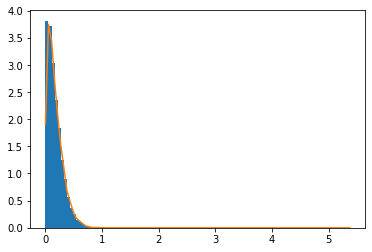

Histogram for F Test feature  23


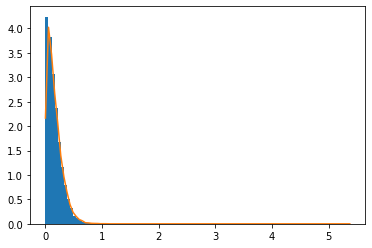

Histogram for F Test feature  24


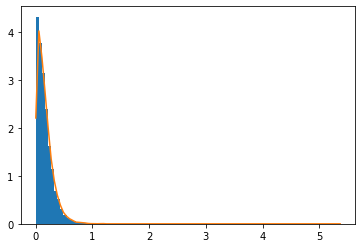

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.2871
LR Accuracy on test data - All features:  0.1476
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.2681
Logistic Regression Accuracy on test data - rotated:  0.1491
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.2874
Logistic Regression Accuracy on test data - rotated:  0.1482
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2841
Logistic Regression Accuracy on test data - rotated:  0.1466
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2852
Logistic Regression Accuracy on test data - rotated:  0.1492
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2831
Logistic Regression Accuracy on test data - rotated:  0.1474
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2865
Logistic Regression Accuracy on test data - rotated:  0.1456
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2841
Logistic Regression Accuracy on test data - rotated:  0.147
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2857
Logistic Regression Accuracy on test data - rotated:  0.1471
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2856
Logistic Regression Accuracy on test data - rotated:  0.1477
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2818
Logistic Regression Accuracy on test data - rotated:  0.1475
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2789
Logistic Regression Accuracy on test data - rotated:  0.1486
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1433
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2837
Logistic Regression Accuracy on test data - rotated:  0.1473
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2846
Logistic Regression Accuracy on test data - rotated:  0.146
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.269
Logistic Regression Accuracy on test data - rotated:  0.1413
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1466
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2856
Logistic Regression Accuracy on test data - rotated:  0.1462
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.282
Logistic Regression Accuracy on test data - rotated:  0.1436
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2824
Logistic Regression Accuracy on test data - rotated:  0.1462
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2855
Logistic Regression Accuracy on test data - rotated:  0.147
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2834
Logistic Regression Accuracy on test data - rotated:  0.1479
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2855
Logistic Regression Accuracy on test data - rotated:  0.1468
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2836
Logistic Regression Accuracy on test data - rotated:  0.1431
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2875
Logistic Regression Accuracy on test data - rotated:  0.1473
Accuracy for without feature  24
Logistic Regression Accuracy within training data - not rotated:  0.2796
Logistic Regression Accuracy on test data - rotated:  0.1468


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [1,10,100,1000,10000,100000,1000000]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.05) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_rotation_labels)/2),:] - Z[int(len(train_rotation_labels)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = rotation_coefficients @ rotation_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    print("Printing eigenvalues")
    print(eigenvalues.shape)
    print(eigenvalues)
    print("Printing eigenvectors")
    display(eigenvectors.shape)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = rotation_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_rotated = torch.from_numpy(np.linalg.lstsq(L, Z_test_rotated.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_rotated.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Trained on original images, tested on rotated images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    X_torch_train = F_test_original
    X_torch_test = F_test_rotated
    X_torch_test_within = F_test_original

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)


    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_test_within))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))

    
    


    # Trained on original images, tested on rotated images: Rotation Features removed from F_test

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_test_original.detach().numpy().copy()
        X_torch_test = F_test_rotated.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)

        print('Logistic Regression Accuracy within training data - not rotated: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
        print('Logistic Regression Accuracy on test data - rotated: ', logistic_regression_model.score(X_torch_test, targets_test))




